In [12]:
pip install statsmodels tensorflow pandas scikit-learn yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import yfinance as yf
import pandas as pd

def download_nasdaq100_data(start_date, end_date):

  # Download the NASDAQ 100 index data
  nasdaq100 = yf.download("^NDX", start=start_date, end=end_date)

  return nasdaq100

if __name__ == "__main__":
  start_date = "2020-01-01"
  end_date = "2024-01-01"
  nasdaq100_data = download_nasdaq100_data(start_date, end_date)
  nasdaq100_data.to_csv("nasdaq100_data.csv")


[*********************100%%**********************]  1 of 1 completed


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ฟังก์ชันคำนวณ RSI
def compute_RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# โหลดข้อมูล OHLC
data = pd.read_csv('data/nasdaq100_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# สร้างตัวชี้วัดทางเทคนิค
data['SMA'] = data['Close'].rolling(window=14).mean()
data['EMA'] = data['Close'].ewm(span=14, adjust=False).mean()
data['RSI'] = compute_RSI(data['Close'])

# เตรียมข้อมูลสำหรับการทำนาย
# สร้างข้อมูล X และ y
X = data[['Open', 'High', 'Low', 'Close', 'SMA', 'EMA', 'RSI']]
y = data['Close'].shift(-1)

# ลบแถวที่มีค่า NaN ออกพร้อมกันใน X และ y
X, y = X.align(y, join='inner', axis=0)

# แยกข้อมูล train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [34]:
X_train.head(5)


,Open,High,Low,Close,SMA,EMA,RSI
Date,,,,,,,
2023-03-14,12078.459961,12217.870117,12035.219727,12199.790039,12081.646484,12104.058832,53.582214
2023-03-15,12083.240234,12269.450195,12026.179688,12251.320312,12086.730818,12123.693696,51.975792
2023-03-16,12211.870117,12595.690430,12190.650391,12581.389648,12130.426479,12184.719823,65.923251
2023-03-17,12570.160156,12674.339844,12444.080078,12519.879883,12163.432896,12229.407831,62.197046
2023-03-20,12487.790039,12578.349609,12407.820312,12562.610352,12200.610770,12273.834834,63.545050


In [35]:
X_test.head(5)

,Open,High,Low,Close,SMA,EMA,RSI
Date,,,,,,,
2023-03-14,12078.459961,12217.870117,12035.219727,12199.790039,12081.646484,12104.058832,53.582214
2023-03-15,12083.240234,12269.450195,12026.179688,12251.320312,12086.730818,12123.693696,51.975792
2023-03-16,12211.870117,12595.690430,12190.650391,12581.389648,12130.426479,12184.719823,65.923251
2023-03-17,12570.160156,12674.339844,12444.080078,12519.879883,12163.432896,12229.407831,62.197046
2023-03-20,12487.790039,12578.349609,12407.820312,12562.610352,12200.610770,12273.834834,63.545050


In [36]:
y_train

Date
2020-01-02     8793.900391
2020-01-03     8848.519531
2020-01-06     8846.450195
2020-01-07     8912.370117
2020-01-08     8989.629883
                  ...     
2023-03-07    12215.330078
2023-03-08    11995.879883
2023-03-09    11830.280273
2023-03-10    11923.169922
2023-03-13    12199.790039
Name: Close, Length: 804, dtype: float64

In [37]:
y_test


Date
2023-03-14    12251.320312
2023-03-15    12581.389648
2023-03-16    12519.879883
2023-03-17    12562.610352
2023-03-20    12741.440430
                  ...     
2023-12-22    16878.460938
2023-12-26    16906.800781
2023-12-27    16898.470703
2023-12-28    16825.929688
2023-12-29             NaN
Name: Close, Length: 202, dtype: float64

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Optimize ARIMA model using Grid Search
def optimize_arima(train_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train_data, order=(p,d,q))
                    model_fit = model.fit()
                    y_pred = model_fit.forecast(steps=len(X_test))
                    y_pred = y_pred[:len(y_train)]
                    error = mean_squared_error(y_train[:len(y_pred)], y_pred)
                    if error < best_score:
                        best_score, best_cfg = error, (p,d,q)
                except:
                    continue
    return best_cfg

# Define range of parameters
p_values = range(1, 6)
d_values = range(0, 2)
q_values = range(0, 2)

# Find best ARIMA parameters
best_arima_cfg = optimize_arima(y_train, p_values, d_values, q_values)

# Train ARIMA model using the optimal configuration
arima_model = ARIMA(y_train, order=best_arima_cfg)
arima_model_fit = arima_model.fit()

# Forecast with ARIMA model
arima_pred = arima_model_fit.forecast(steps=len(X_test))
arima_pred_aligned = arima_pred[:len(y_test)]

c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is ava

In [12]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Scale the input features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Prepare data for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create and train the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, verbose=1)

# Predict with LSTM model
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)



c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: nan  
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan 
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan
Epoch 16/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: na

In [13]:
# Train Random Forest model with basic hyperparameters
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,  # Increase the number of trees for better performance
    max_depth=15,  # Increase depth for better learning
    min_samples_split=3,  # Adjust for more detailed splits
    min_samples_leaf=1,  # Adjust for better performance
    random_state=42  # Set random state for reproducibility
)
rf_model.fit(X_train, y_train)

# Predict with Random Forest model
rf_pred = rf_model.predict(X_test)

# Combine predictions for ensemble
X_test_stacked = np.column_stack((lstm_pred, rf_pred))

In [14]:
rf_pred

array([12116.27937142, 12332.79467993, 12601.96654572, 12535.88687819,
       12601.03043637, 12542.26561239, 12630.93091707, 12711.31397545,
       12645.50574815, 12613.99273633, 12566.35716781, 12818.44511888,
       12966.75537159, 13103.49515742, 13142.78528849, 13145.00973099,
       13009.05737363, 13090.39810512, 13103.62733813, 12994.99713689,
       12856.60613328, 13054.99069793, 13140.53642472, 13214.67792883,
       13191.36736141, 13183.63067175, 13034.19839547, 13073.25146928,
       13035.60229651, 12917.25847995, 12994.12902597, 13026.32468416,
       13258.8764403 , 13258.76403755, 13185.6279595 , 13111.23577872,
       13022.50953683, 13199.09193469, 13245.191192  , 13149.45875344,
       13305.48836247, 13377.47990817, 13396.16367244, 13332.02930856,
       13324.62242868, 13603.65498958, 13798.29027547, 13890.71401053,
       13906.94484732, 13618.84293129, 13636.28017822, 14013.25896513,
       14262.18811985, 14405.00901298, 14203.73160221, 14431.14371745,
      

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import tensorflow as tf

class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y, **kwargs):
        # Ensure X is reshaped for LSTM: (samples, timesteps, features)
        if len(X.shape) == 2:
            X = X.reshape((X.shape[0], 1, X.shape[1]))
        self.model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        # Ensure X is reshaped for LSTM: (samples, timesteps, features)
        if len(X.shape) == 2:
            X = X.reshape((X.shape[0], 1, X.shape[1]))
        return self.model.predict(X)


In [15]:
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

# ทำนายด้วย ARIMA
arima_pred = arima_model_fit.forecast(steps=len(X_test))
arima_pred_aligned = arima_pred[:len(y_train)]  # ตัวอย่างการ align ผลลัพธ์ ARIMA

# ทำนายด้วย LSTM
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_train_pred = scaler_y.inverse_transform(lstm_train_pred)

# ทำนายด้วย Random Forest
rf_pred_aligned = rf_model.predict(X_train)

# ตรวจสอบขนาดของการทำนายแต่ละแบบ
print("Shape of ARIMA predictions:", arima_pred_aligned.shape)
print("Shape of LSTM predictions:", lstm_train_pred.shape)
print("Shape of RF predictions:", rf_pred_aligned.shape)

# ตรวจสอบและปรับขนาดให้ตรงกัน
min_length = min(len(arima_pred_aligned), len(lstm_train_pred), len(rf_pred_aligned))

# ปรับขนาดการทำนายให้สอดคล้องกัน
arima_pred_aligned = arima_pred_aligned[:min_length]
lstm_train_pred = lstm_train_pred[:min_length]
rf_pred_aligned = rf_pred_aligned[:min_length]

# รวมการทำนายที่ถูกปรับขนาดแล้วสำหรับการฝึก
X_train_stacked = np.column_stack((lstm_train_pred, rf_pred_aligned))

# ทำนายด้วย ARIMA สำหรับชุดทดสอบ
arima_pred_test = arima_model_fit.forecast(steps=len(X_test))

# ปรับขนาดการทำนายให้สอดคล้องกันสำหรับชุดทดสอบ
arima_pred_test_aligned = arima_pred_test[:min_length]
lstm_test_pred = lstm_model.predict(X_test_lstm)
lstm_test_pred = scaler_y.inverse_transform(lstm_test_pred)
lstm_test_pred_aligned = lstm_test_pred[:min_length]
rf_pred_test_aligned = rf_model.predict(X_test)[:min_length]

# รวมการทำนายที่ถูกปรับขนาดแล้วสำหรับการทดสอบ
X_test_stacked = np.column_stack((lstm_test_pred_aligned, rf_pred_test_aligned))

# สร้างและฝึกโมเดล Stacking
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model)
    ],
    final_estimator=LinearRegression()
)

# ฝึกโมเดล Stacking
stacked_model.fit(X_train_stacked, y_train[:min_length])

# ทำนายด้วยโมเดล Stacking
ensemble_pred = stacked_model.predict(X_test_stacked)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wibun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the n

Shape of ARIMA predictions: (202,)
Shape of LSTM predictions: (804, 1)
Shape of RF predictions: (804,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [25]:
ensemble_pred

array([12487.29564639, 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
      

Mean Squared Error of the Ensemble Model: 5936389.483695794


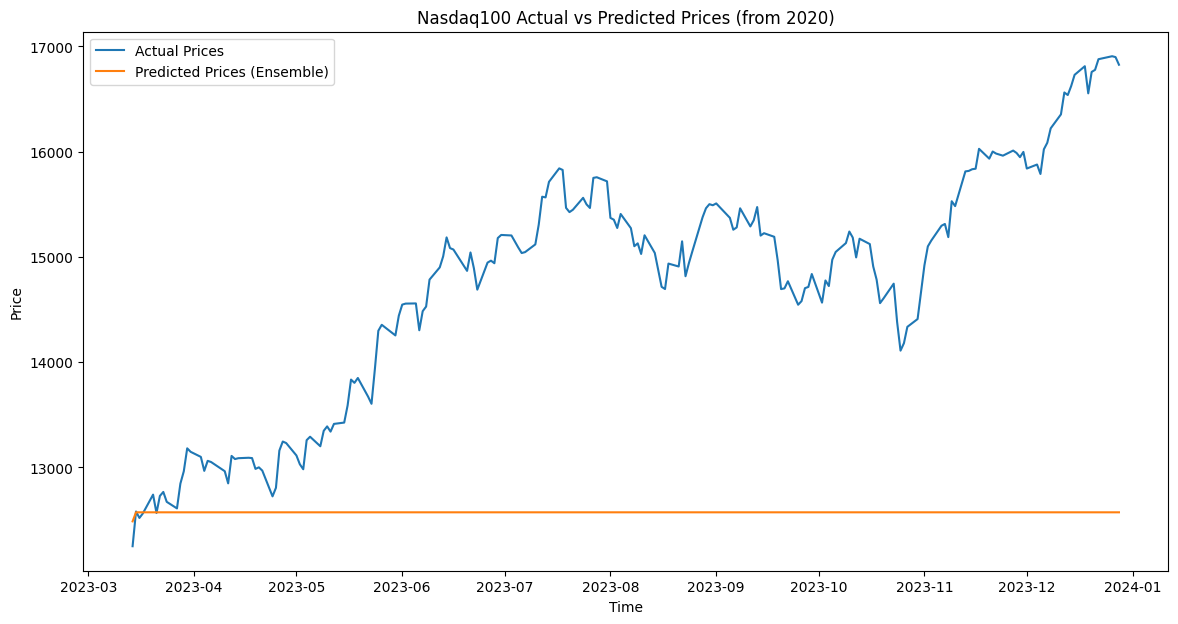

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Convert NumPy arrays to Pandas Series
y_test_series = pd.Series(y_test, index=X_test.index)  # Set the index to match the date index
ensemble_pred_series = pd.Series(ensemble_pred, index=X_test.index[:len(ensemble_pred)])  # Match prediction index with test dates

# Handle any NaN values
y_test_series = y_test_series.dropna()
ensemble_pred_series = ensemble_pred_series.dropna()

# Align lengths if necessary
min_length = min(len(y_test_series), len(ensemble_pred_series))
y_test_series = y_test_series[:min_length]
ensemble_pred_series = ensemble_pred_series[:min_length]

# Ensure datetime index is correctly handled
y_test_series.index = pd.to_datetime(y_test_series.index, errors='coerce')
ensemble_pred_series.index = pd.to_datetime(ensemble_pred_series.index, errors='coerce')

# Filter for data starting from 2020
start_date = '2020-01-01'
y_test_series = y_test_series[y_test_series.index >= start_date]
ensemble_pred_series = ensemble_pred_series[ensemble_pred_series.index >= start_date]

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_series, ensemble_pred_series)
print(f'Mean Squared Error of the Ensemble Model: {mse}')

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_test_series.index, y_test_series.values, label='Actual Prices')
plt.plot(ensemble_pred_series.index, ensemble_pred_series.values, label='Predicted Prices (Ensemble)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Nasdaq100 Actual vs Predicted Prices (from 2020)')
plt.show()


In [23]:
y_test_series

Date
2023-03-14    12251.320312
2023-03-15    12581.389648
2023-03-16    12519.879883
2023-03-17    12562.610352
2023-03-20    12741.440430
                  ...     
2023-12-21    16777.400391
2023-12-22    16878.460938
2023-12-26    16906.800781
2023-12-27    16898.470703
2023-12-28    16825.929688
Name: Close, Length: 201, dtype: float64

In [27]:
ensemble_pred

array([12487.29564639, 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
       12573.5103429 , 12573.5103429 , 12573.5103429 , 12573.5103429 ,
      